# **Classification of Customer Reviews**




#Importing Needed packages
## **Objectives**
* Developing Machine learning models to classify Customer reviews


In [ ]:
import json
import pandas as pd


In [ ]:

import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,precision_score, recall_score

import re
import spacy
sp = spacy.load('en_core_web_sm')

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader,TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import time
import datetime

import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 10,5

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from transformers import RobertaModel, RobertaTokenizer

# Load pre-trained model tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Load pre-trained model
model = RobertaModel.from_pretrained('roberta-base')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers

In [ ]:
!pip install langdetect

# yelp_academic_dataset_review

# upload Data

In [ ]:
data_file_review = open("yelp_academic_dataset_review.json")

data_review = []
for line in data_file_review:
        data_review.append(json.loads(line))


In [ ]:
review_df = pd.DataFrame(data_review)

In [ ]:
# Assuming 'df' is your DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
review_df.head(10)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
8,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
9,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06


# Data Exploration
* Let's first have a descriptive exploration on our data.


In [ ]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    20000 non-null  object 
 1   user_id      20000 non-null  object 
 2   business_id  20000 non-null  object 
 3   stars        20000 non-null  float64
 4   useful       20000 non-null  int64  
 5   funny        20000 non-null  int64  
 6   cool         20000 non-null  int64  
 7   text         20000 non-null  object 
 8   date         20000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ MB


In [ ]:
review_df.describe()

,stars,useful,funny,cool
count,20000.000000,20000.000000,20000.000000,20000.00000
mean,3.852350,0.886300,0.253350,0.34220
std,1.349163,1.937436,0.945044,1.06111
min,1.000000,0.000000,0.000000,0.00000
25%,3.000000,0.000000,0.000000,0.00000
50%,4.000000,0.000000,0.000000,0.00000
75%,5.000000,1.000000,0.000000,0.00000
max,5.000000,91.000000,26.000000,44.00000


In [ ]:
print(review_df.isnull().sum())


review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


In [ ]:
yelp_df = review_df[['stars','text']]

In [ ]:
# 0-->negative
# 1-->positive
# remove the reviews with stars equal 3.0

# yelp_df['feedback'] = yelp_df['stars'].apply(lambda x: 1 if x > 3 else 0)
yelp_df['feedback'] = yelp_df['stars'].apply(lambda x: int(1) if x > 3 else int(0) if x < 3 else -1)
yelp_df= yelp_df[(yelp_df["stars"]!=3)]

<ipython-input-13-2176f947f8db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_df['feedback'] = yelp_df['stars'].apply(lambda x: int(1) if x > 3 else int(0) if x < 3 else -1)


In [ ]:
yelp = yelp_df[(yelp_df["stars"]!=3)]

yelp_df.head(10)

,stars,text,feedback
1,5.0,I've taken a lot of spin classes over the year...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",1
4,4.0,Cute interior and owner (?) gave us tour of up...,1
5,1.0,I am a long term frequent customer of this est...,0
6,5.0,Loved this tour! I grabbed a groupon and the p...,1
7,5.0,Amazingly amazing wings and homemade bleu chee...,1
10,5.0,My experience with Shalimar was nothing but wo...,1
11,4.0,"Locals recommended Milktooth, and it's an amaz...",1
12,4.0,Love going here for happy hour or dinner! Gre...,1
13,4.0,Good food--loved the gnocchi with marinara\nth...,1


In [ ]:
yelp_df['feedback'].value_counts()

1    14031
0     3728
Name: feedback, dtype: int64

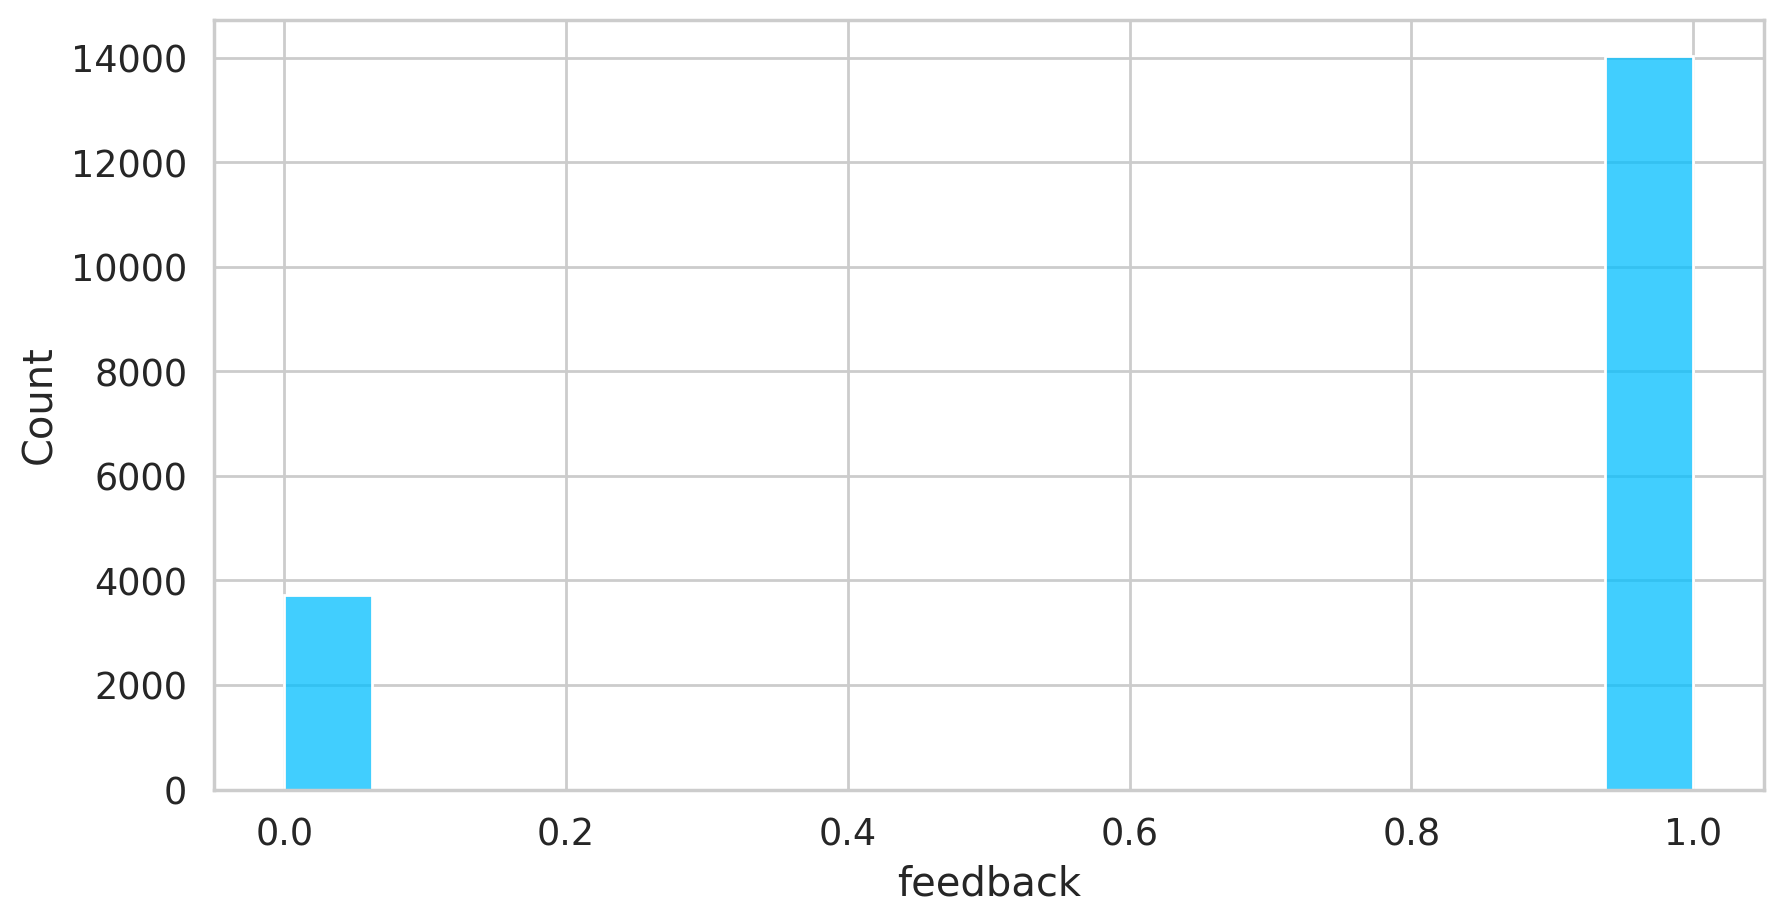

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Histogram
sns.histplot(yelp_df['feedback'])
plt.show()

## Balancing the dataset

In [ ]:
# separate the data
yelp_P_feedback = yelp_df[yelp_df['feedback']==1] #positive feedback
yelp_N_feedback = yelp_df[yelp_df['feedback']==0] #Negative feedback


In [ ]:
#here we will depend on the how many negative feedback we have to balance our data
yelp_P_feedback = yelp_P_feedback.sample(yelp_N_feedback.shape[0])


In [ ]:
# concatinate the positive and negative row
yelp_balanced_df = yelp_N_feedback.append(yelp_P_feedback, ignore_index=True)

<ipython-input-19-a5d7c81c8d9a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yelp_balanced_df = yelp_N_feedback.append(yelp_P_feedback, ignore_index=True)


In [ ]:
# shuffle the data
yelp_balanced_df = yelp_balanced_df.sample(frac=1).reset_index(drop=True)

In [ ]:
yelp_balanced_df['feedback'].value_counts()

1    3728
0    3728
Name: feedback, dtype: int64

In [ ]:
yelp=yelp_balanced_df

In [ ]:
yelp['text length'] = yelp['text'].apply(len)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

###We use FacetGrid from the seaborn library to create a grid of 5 histograms of text length based off of the star ratings

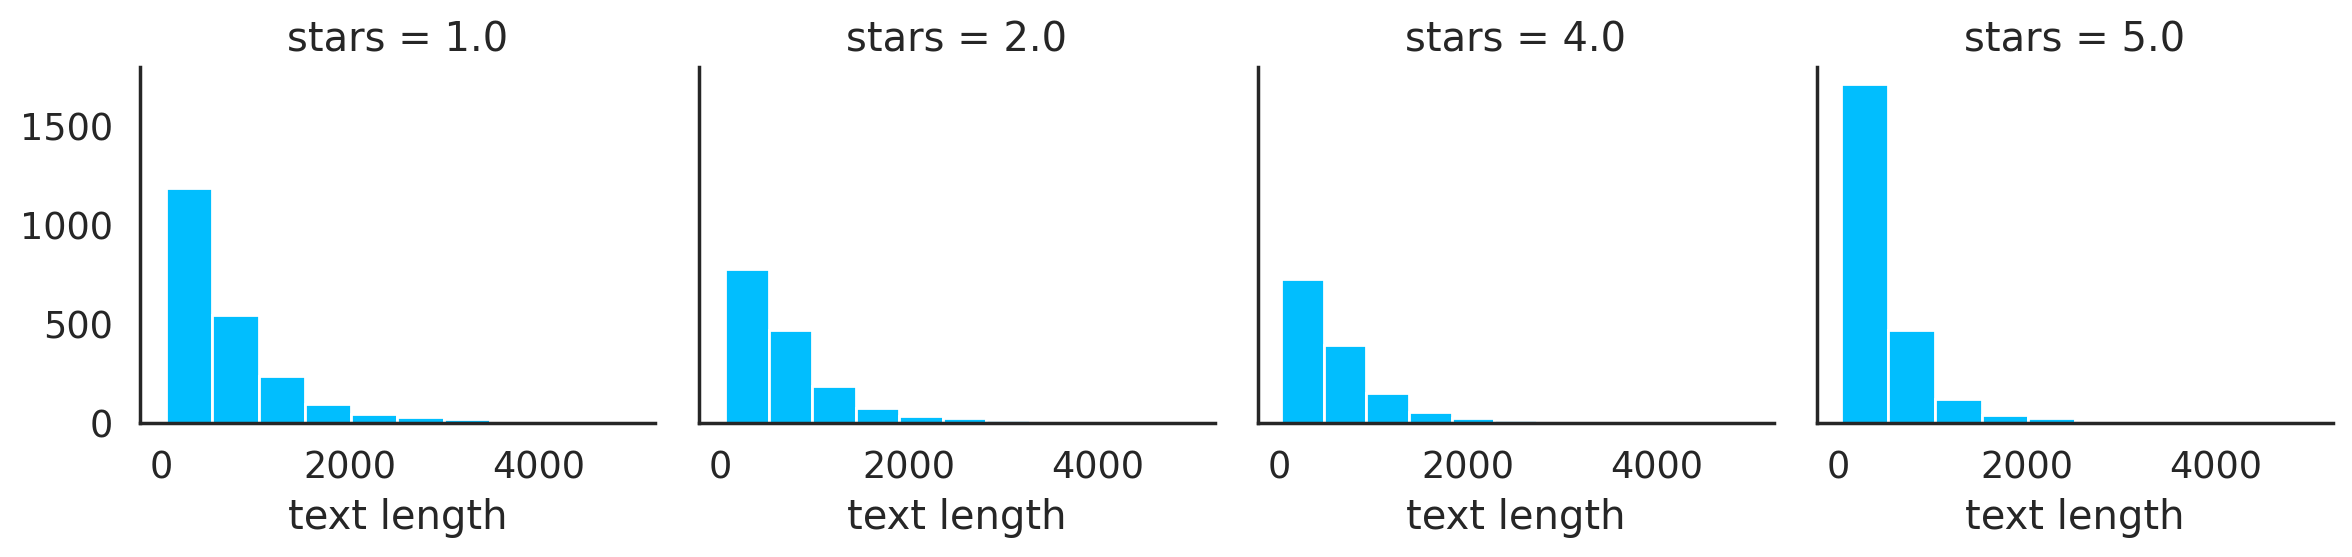

In [ ]:
g = sns.FacetGrid(yelp, col = 'stars')
g.map(plt.hist, 'text length')

#**Data Preprocessing**

###We will only analyse the reviews written in English

In [ ]:
from langdetect import detect
yelp['detect'] = yelp['text'].apply(detect)
yelp = yelp[yelp['detect'] == 'en'].reset_index(drop=True)


In [ ]:
#Check if there is NaN values
yelp.isnull().values.any()

False

In [ ]:
yelp.drop_duplicates(inplace=True)

In [ ]:
yelp.drop('stars', axis=1, inplace=True)

In [ ]:
yelp.head(10)

,text,feedback,text length,detect
0,Great clothing at a great price. They have sui...,1,245,en
1,Great local pizza with awesome owner and emplo...,1,305,en
2,What a wonderful weekend at the Peppermill. Ve...,1,461,en
3,"The food here is so good, they have a great pa...",1,199,en
4,Although I lack the gene that allows a person ...,1,2419,en
5,I would have rather put a hundred dollars down...,0,442,en
6,"Always have a great time here, and tonight was...",1,190,en
7,Some recent improvements in the practice: new...,1,545,en
8,I still love this place just as much as I ever...,1,955,en
9,I love El Sitio...in Isla Vista. I ordered a b...,0,292,en


##Stopwords with spaCy. As 'no' and 'not' are important words to describe an opinion about a restaurant (e.g. not cheap, not a good service, no napkins available, etc.), we should, at least, remove those two words from the stopwords.

In [ ]:
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

exclude_stopwords = ['no','not']
for word in exclude_stopwords:
    stopwords.remove(word)

###UDF to remove non-letters, convert to lower case, tokenize with NLTK and remove the spaCy stopwords from the restaurant reviews:

In [ ]:
# The input is a single string (a raw restaurant review), and the output is a single string (a preprocessed restaurant review)

def text_preprocessing( raw_review ):
    # 1. Remove non-letters
    review_text_letters_only = re.sub("[^a-zA-Z]", " ", raw_review)
    # 2. Convert to lower case
    review_preprocessed = review_text_letters_only.lower()
    # 3. Word tokenization
    review_tokens = word_tokenize(review_preprocessed)
    # 4. Filter the stopwords
    filtered_sentence =[]
    for word in review_tokens:
        lexeme = sp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)

    return " ".join(filtered_sentence)

###Apply the above UDF to the entire 'restaurant_reviews' column, creating a new column named 'cleaned_reviews'

In [ ]:
yelp['cleaned_reviews'] = yelp['text'].apply(text_preprocessing)

In [ ]:
yelp= yelp.reset_index(drop=True)

In [ ]:
yelp.head()

,text,feedback,text length,detect,cleaned_reviews
0,Great clothing at a great price. They have sui...,1,245,en,great clothing great price suits tuxedos high ...
1,Great local pizza with awesome owner and emplo...,1,305,en,great local pizza awesome owner employees auth...
2,What a wonderful weekend at the Peppermill. Ve...,1,461,en,wonderful weekend peppermill helpful pleasant ...
3,"The food here is so good, they have a great pa...",1,199,en,food good great patio staff attentive professi...
4,Although I lack the gene that allows a person ...,1,2419,en,lack gene allows person excited sports love se...


####Before we are ready to encode our reviews we need to decide on a maximum sentence length. BERT expects fixed-length sequences, let's choose maximum sequence length:

In [ ]:
token_lens = []

for txt in yelp.cleaned_reviews:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

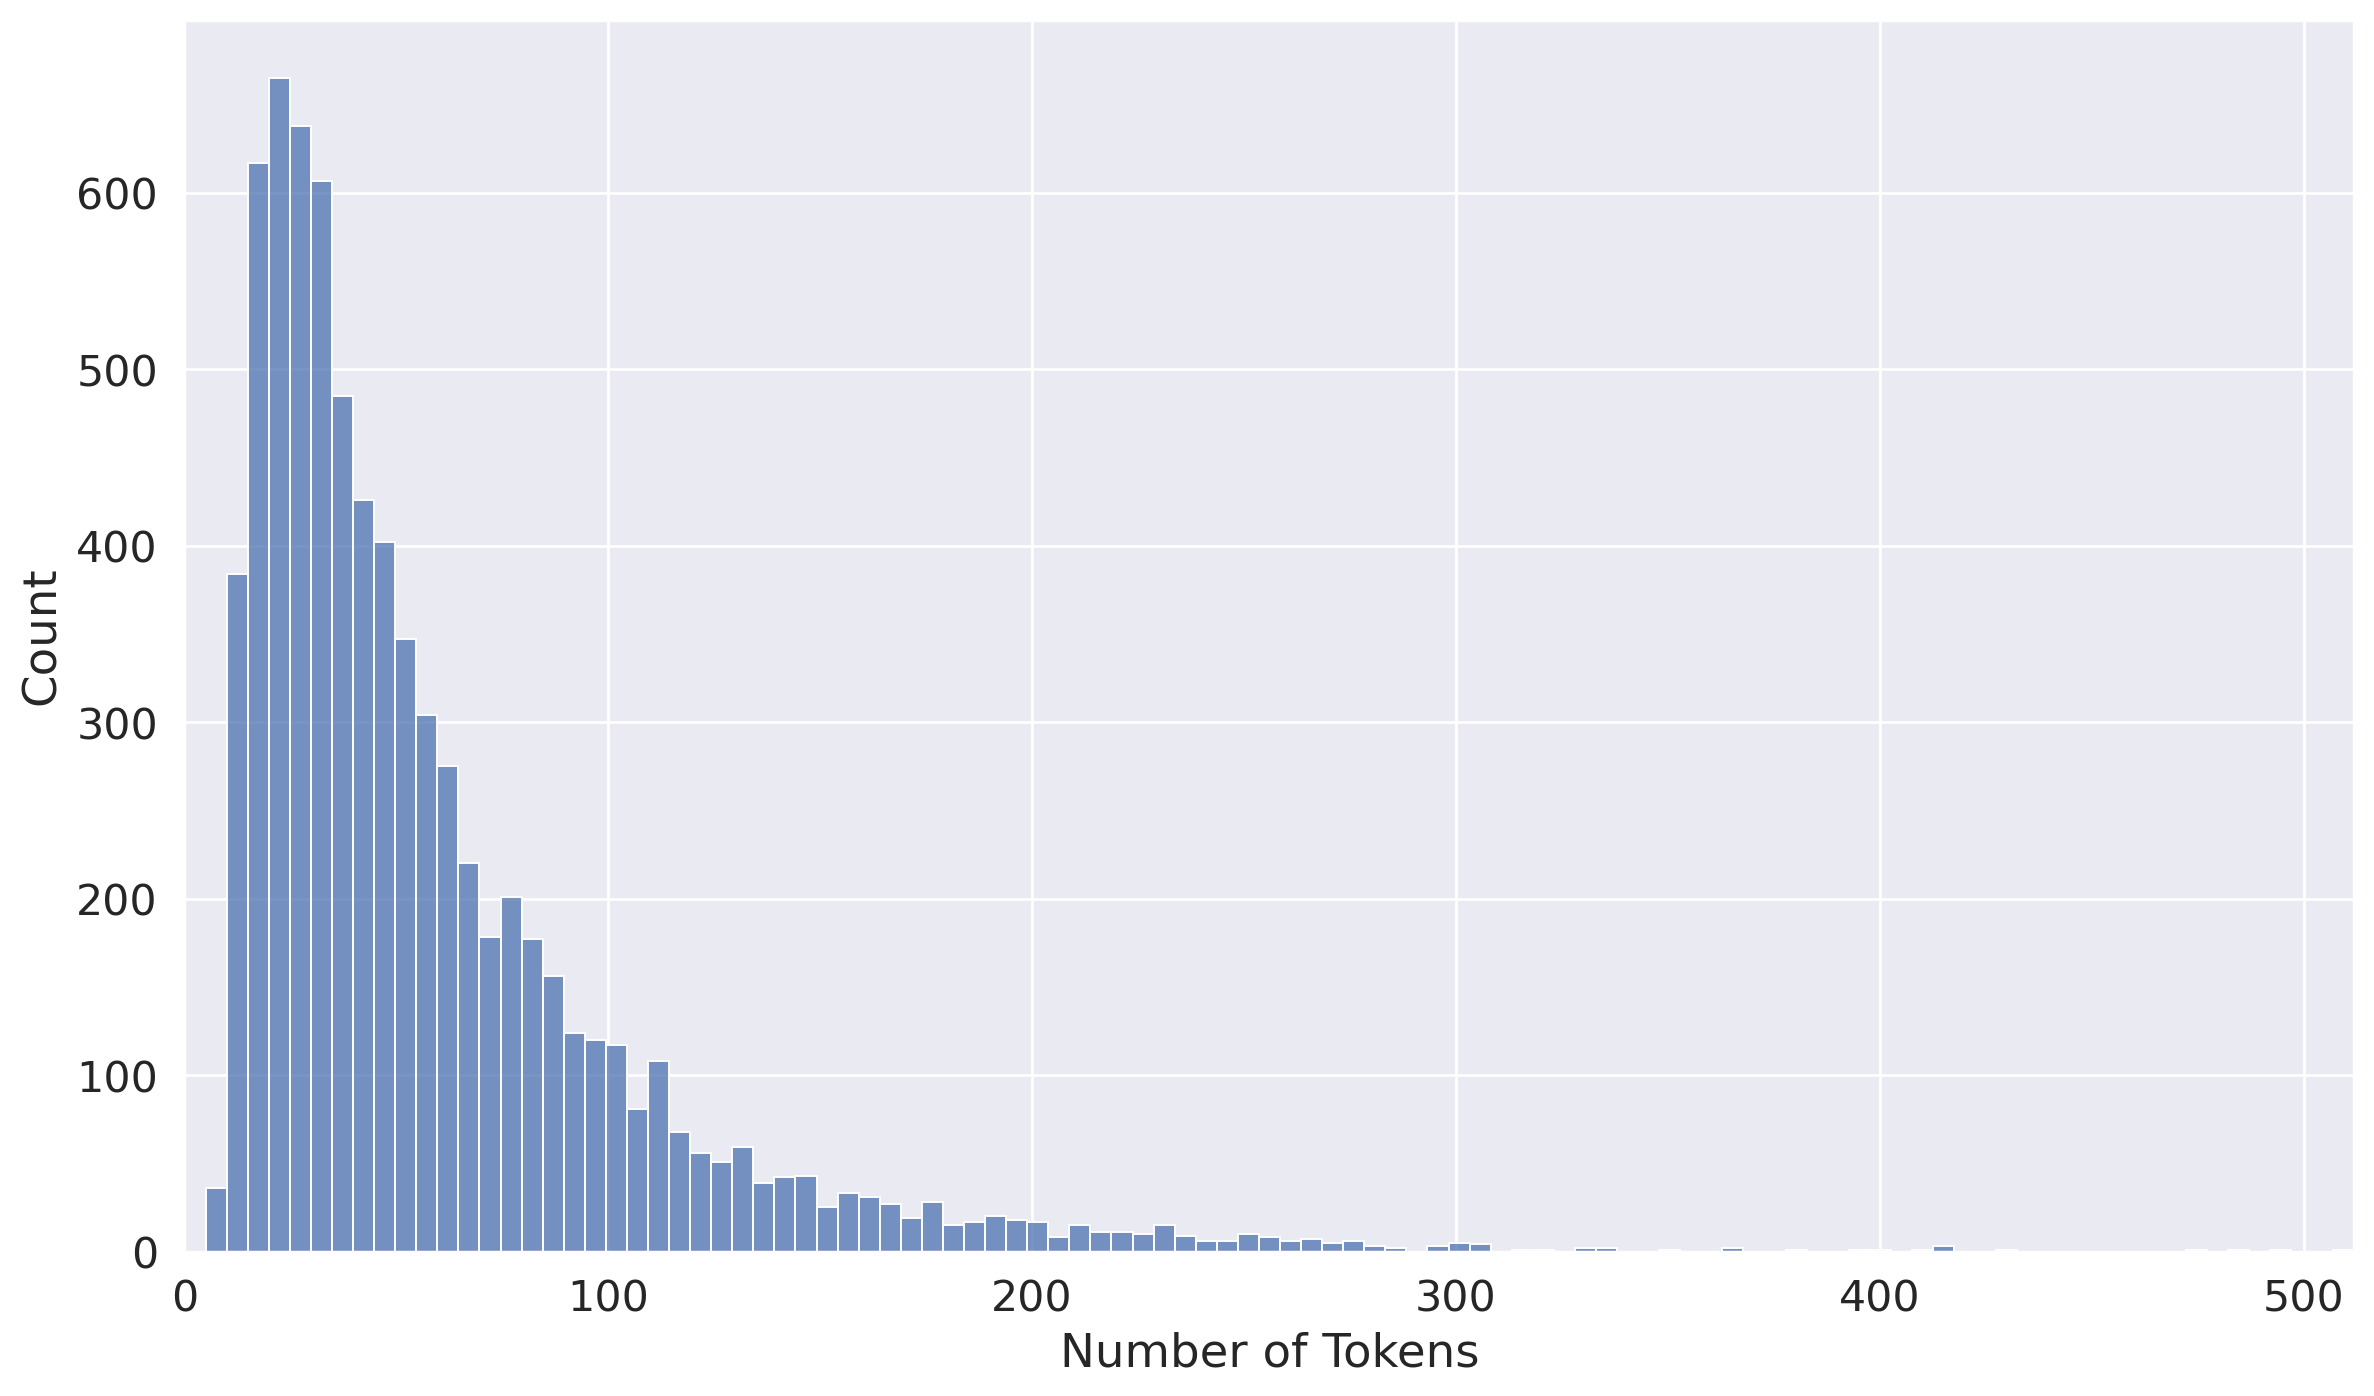

In [ ]:
sns.set(font_scale=1.4)
plt.rcParams["figure.figsize"] = (14,8)
sns.histplot(token_lens)
plt.xlim([0, 512])
plt.xlabel('Number of Tokens')
plt.show()

###The great majority of the reviews seems to have less than 240 tokens, that's the maximum length that we'll choose.

In [ ]:
MAX_SEQ_LENGTH = 240

In [ ]:
df=yelp
df = df.rename(columns={'text': 'reviews'})
df = df.rename(columns={'feedback': 'sentiment'})
df.head()

,reviews,sentiment,text length,detect,cleaned_reviews
0,Great clothing at a great price. They have sui...,1,245,en,great clothing great price suits tuxedos high ...
1,Great local pizza with awesome owner and emplo...,1,305,en,great local pizza awesome owner employees auth...
2,What a wonderful weekend at the Peppermill. Ve...,1,461,en,wonderful weekend peppermill helpful pleasant ...
3,"The food here is so good, they have a great pa...",1,199,en,food good great patio staff attentive professi...
4,Although I lack the gene that allows a person ...,1,2419,en,lack gene allows person excited sports love se...


#**Split the Dataset**

###Split the dataset into train (70 %), validation (15%) and test (15%) sets and preserve the same proportions of observations in each class as observed in the original dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['cleaned_reviews'],df.sentiment, test_size=0.3, random_state = 42, stratify=df.sentiment)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 42, stratify= y_test)

In [ ]:
x_train.head(10)

719     arrived planning saenger minute walk away minu...
7415    ve driven past restaurant literally times toda...
5003    believe adorable spot tucked away mountains tr...
2095    stars customer service appropriate disaster cr...
4754    beer service lackluster beer ordered flavor so...
630     worst experiences place poor cut undercooked m...
6920    meh food told prime rib known wow tough expect...
496     awful shower dispensed boiling hot water unusa...
4680    great experience wanting try mardi gras compli...
6051    taylor home solutions cleaned ducts large home...
Name: cleaned_reviews, dtype: object

In [ ]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

###Convert to list each of the sets

In [ ]:
train_reviews = x_train.tolist()
val_reviews = x_val.tolist()
test_reviews = x_test.tolist()

#Create a sequence of token ids (input ids) for each review

> Indented block




*   **tokenizer.encode** converts a string in a sequence of intput ids (integers) using the tokenizer and the vocabulary, meaning, it splits a string into tokens and map the tokens to their ids.
*   We must add special tokens - [CLS] and [SEP] - for classification tasks.




In [ ]:
# Train dataset
train_input_ids = [tokenizer.encode(train_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(train_reviews))]
# Val dataset
val_input_ids = [tokenizer.encode(val_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(val_reviews))]
# Test dataset
test_input_ids = [tokenizer.encode(test_reviews[i],add_special_tokens = True, max_length=MAX_SEQ_LENGTH, truncation=True) for i in range(0,len(test_reviews))]

##Padding and truncating: pad and truncate our sequences so that they all have the same length:

*   **Padding**: when necessary, paddding wiil add zeros to make all the sequences reach the length of MAX_SEQ_LENGTH
*   **Truncating**: when necessary, sequences longer than the MAX_SEQ_LENGTH are truncated to MAX_SEQ_LENGTH

*   Note: '**post**' specifies that we want to pad and truncate at the end of the sequence.







In [ ]:
from keras.preprocessing.sequence import pad_sequences    # Pad utility function to pad sequences to maximum length.

# Padding value: is optional, the default is 0.

# Train dataset
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long",
                          value=0, truncating="post", padding="post")

# Validation dataset
val_input_ids = pad_sequences(val_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long",
                          value=0, truncating="post", padding="post")

# Test dataset
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_SEQ_LENGTH, dtype="long",
                          value=0, truncating="post", padding="post")

###**Attention Masks**

###The attention masks differentiate which tokens are real tokens versus which are [PAD] tokens.

In [ ]:
# Create attention masks

# Train dataset
train_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in train_input_ids]
# dev dataset
val_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in val_input_ids]
# Test dataset
test_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in test_input_ids]

##Convert all lists of inputs ids, labels and attention masks into **torch tensors**

In [ ]:
# input_ids
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
test_inputs = torch.tensor(test_input_ids)
# labels
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
test_labels = torch.tensor(y_test.values)
# attention masks
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)
test_masks = torch.tensor(test_attention_masks)

##Create a DataLoader to load our datasets. Serves as an iterator, it saves memory during training when compared with a for loop

In [ ]:
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Number of classes / labels
n_classes = y_train.nunique()
n_classes

2

#**Model Building**

##**Build a sentiment Classifier**

# RoBERTa Model

In [ ]:
from transformers import RobertaModel, RobertaTokenizerFast

In [ ]:
roberta = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for param in roberta.parameters():
 param.requires_grad = False


In [ ]:
import torch
import torch.nn as nn

class RoBERTa_Arch(nn.Module):
    def __init__(self, roberta):
        super(RoBERTa_Arch, self).__init__()
        self.roberta = roberta
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        cls_hs = self.roberta(input_ids, attention_mask=attention_mask)['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=12, save_path='best_model.pth'):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for step, batch in enumerate(train_dataloader):
            batch = [r.to(device) for r in batch]
            input_ids, mask, labels = batch

            optimizer.zero_grad()
            preds = model(input_ids, mask)
            loss = criterion(preds, labels)
            total_loss += loss.item()

            _, predicted = torch.max(preds.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_dataloader:
                batch = [t.to(device) for t in batch]
                sent_id, mask, labels = batch
                preds = model(sent_id, mask)
                val_loss = criterion(preds, labels)
                total_val_loss += val_loss.item()

                _, predicted = torch.max(preds.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Save the model if it has the best validation loss
        if avg_val_loss < best_val_loss:
            print("Saving the best model...")
            torch.save(model.state_dict(), save_path)
            best_val_loss = avg_val_loss

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
roberta_model = RoBERTa_Arch(roberta).to(device)
roberta_optimizer = torch.optim.AdamW(roberta_model.parameters(), lr=1e-4)
roberta_criterion = nn.NLLLoss()

# Train the RoBERTa model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(roberta_model, train_dataloader, val_dataloader, roberta_optimizer, roberta_criterion, num_epochs=12, save_path='roberta_best_model.pth')



Epoch [1/12], Training Loss: 0.6901, Training Accuracy: 0.5297, Validation Loss: 0.6795, Validation Accuracy: 0.5698
Saving the best model...
Epoch [2/12], Training Loss: 0.6781, Training Accuracy: 0.5731, Validation Loss: 0.6665, Validation Accuracy: 0.6091
Saving the best model...
Epoch [3/12], Training Loss: 0.6729, Training Accuracy: 0.5952, Validation Loss: 0.6603, Validation Accuracy: 0.6100
Saving the best model...
Epoch [4/12], Training Loss: 0.6610, Training Accuracy: 0.6119, Validation Loss: 0.6518, Validation Accuracy: 0.6538
Saving the best model...
Epoch [5/12], Training Loss: 0.6492, Training Accuracy: 0.6332, Validation Loss: 0.6456, Validation Accuracy: 0.5939
Saving the best model...
Epoch [6/12], Training Loss: 0.6415, Training Accuracy: 0.6410, Validation Loss: 0.6289, Validation Accuracy: 0.6333
Saving the best model...
Epoch [7/12], Training Loss: 0.6252, Training Accuracy: 0.6614, Validation Loss: 0.6138, Validation Accuracy: 0.7191
Saving the best model...
Epoch 

# Plot Accuracy & Loss

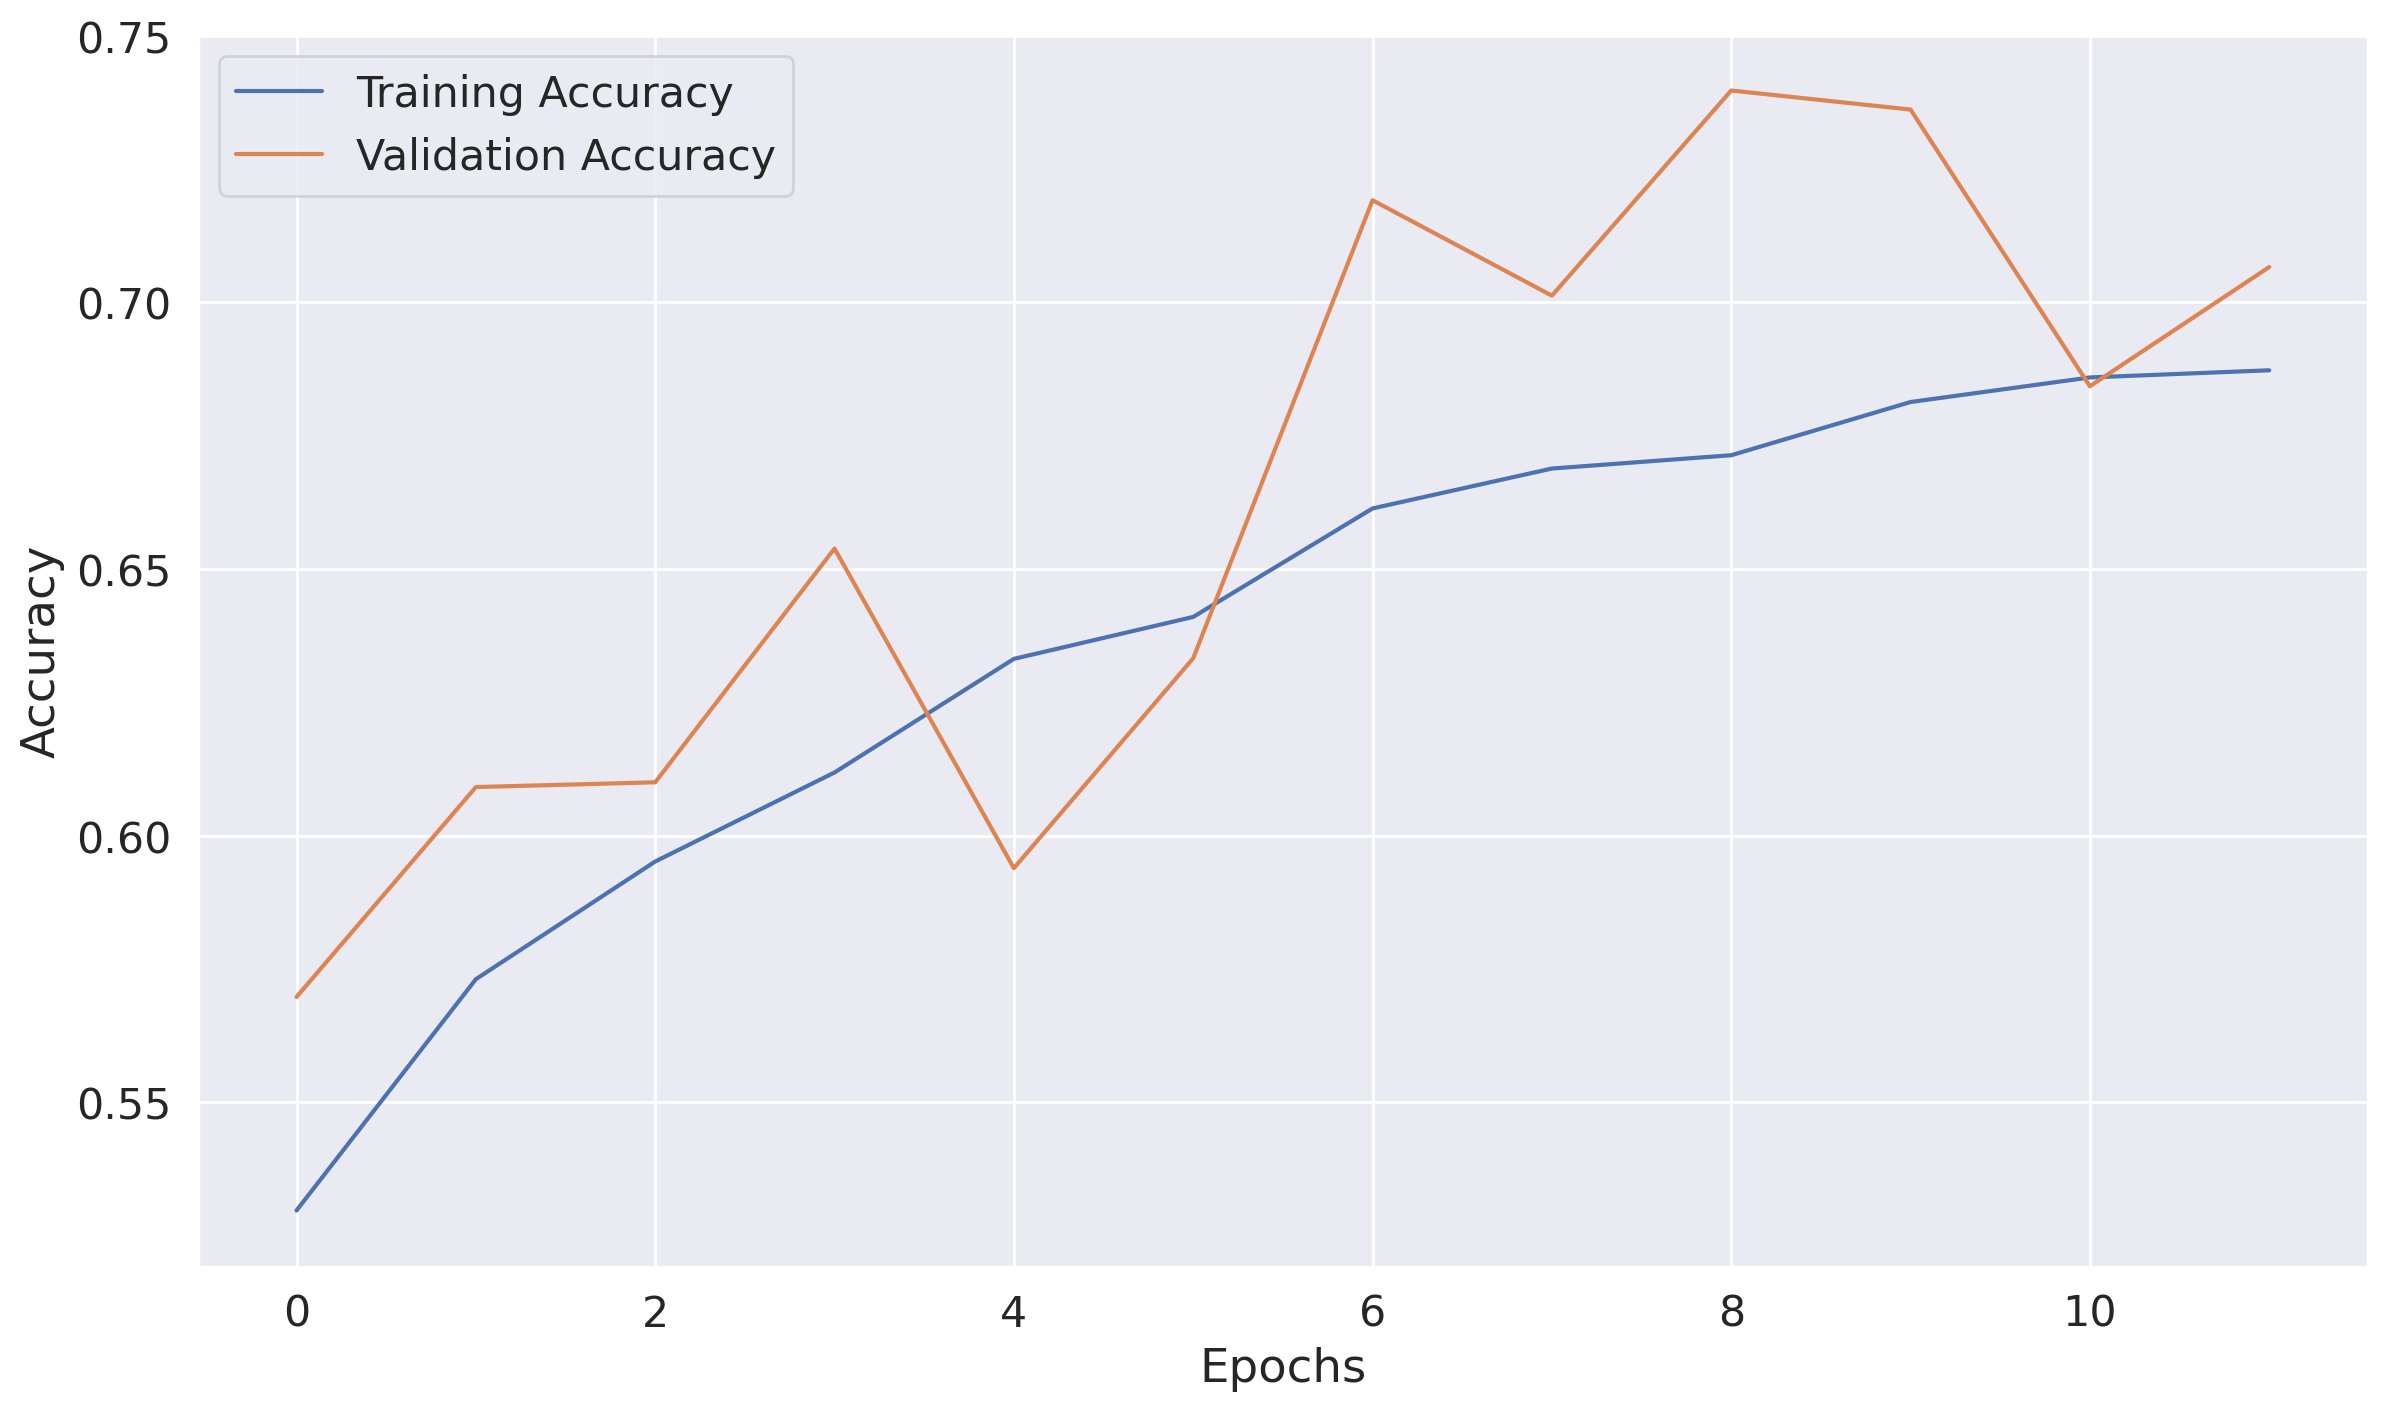

In [ ]:
# Plot the results
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Text(0, 0.5, 'loss')

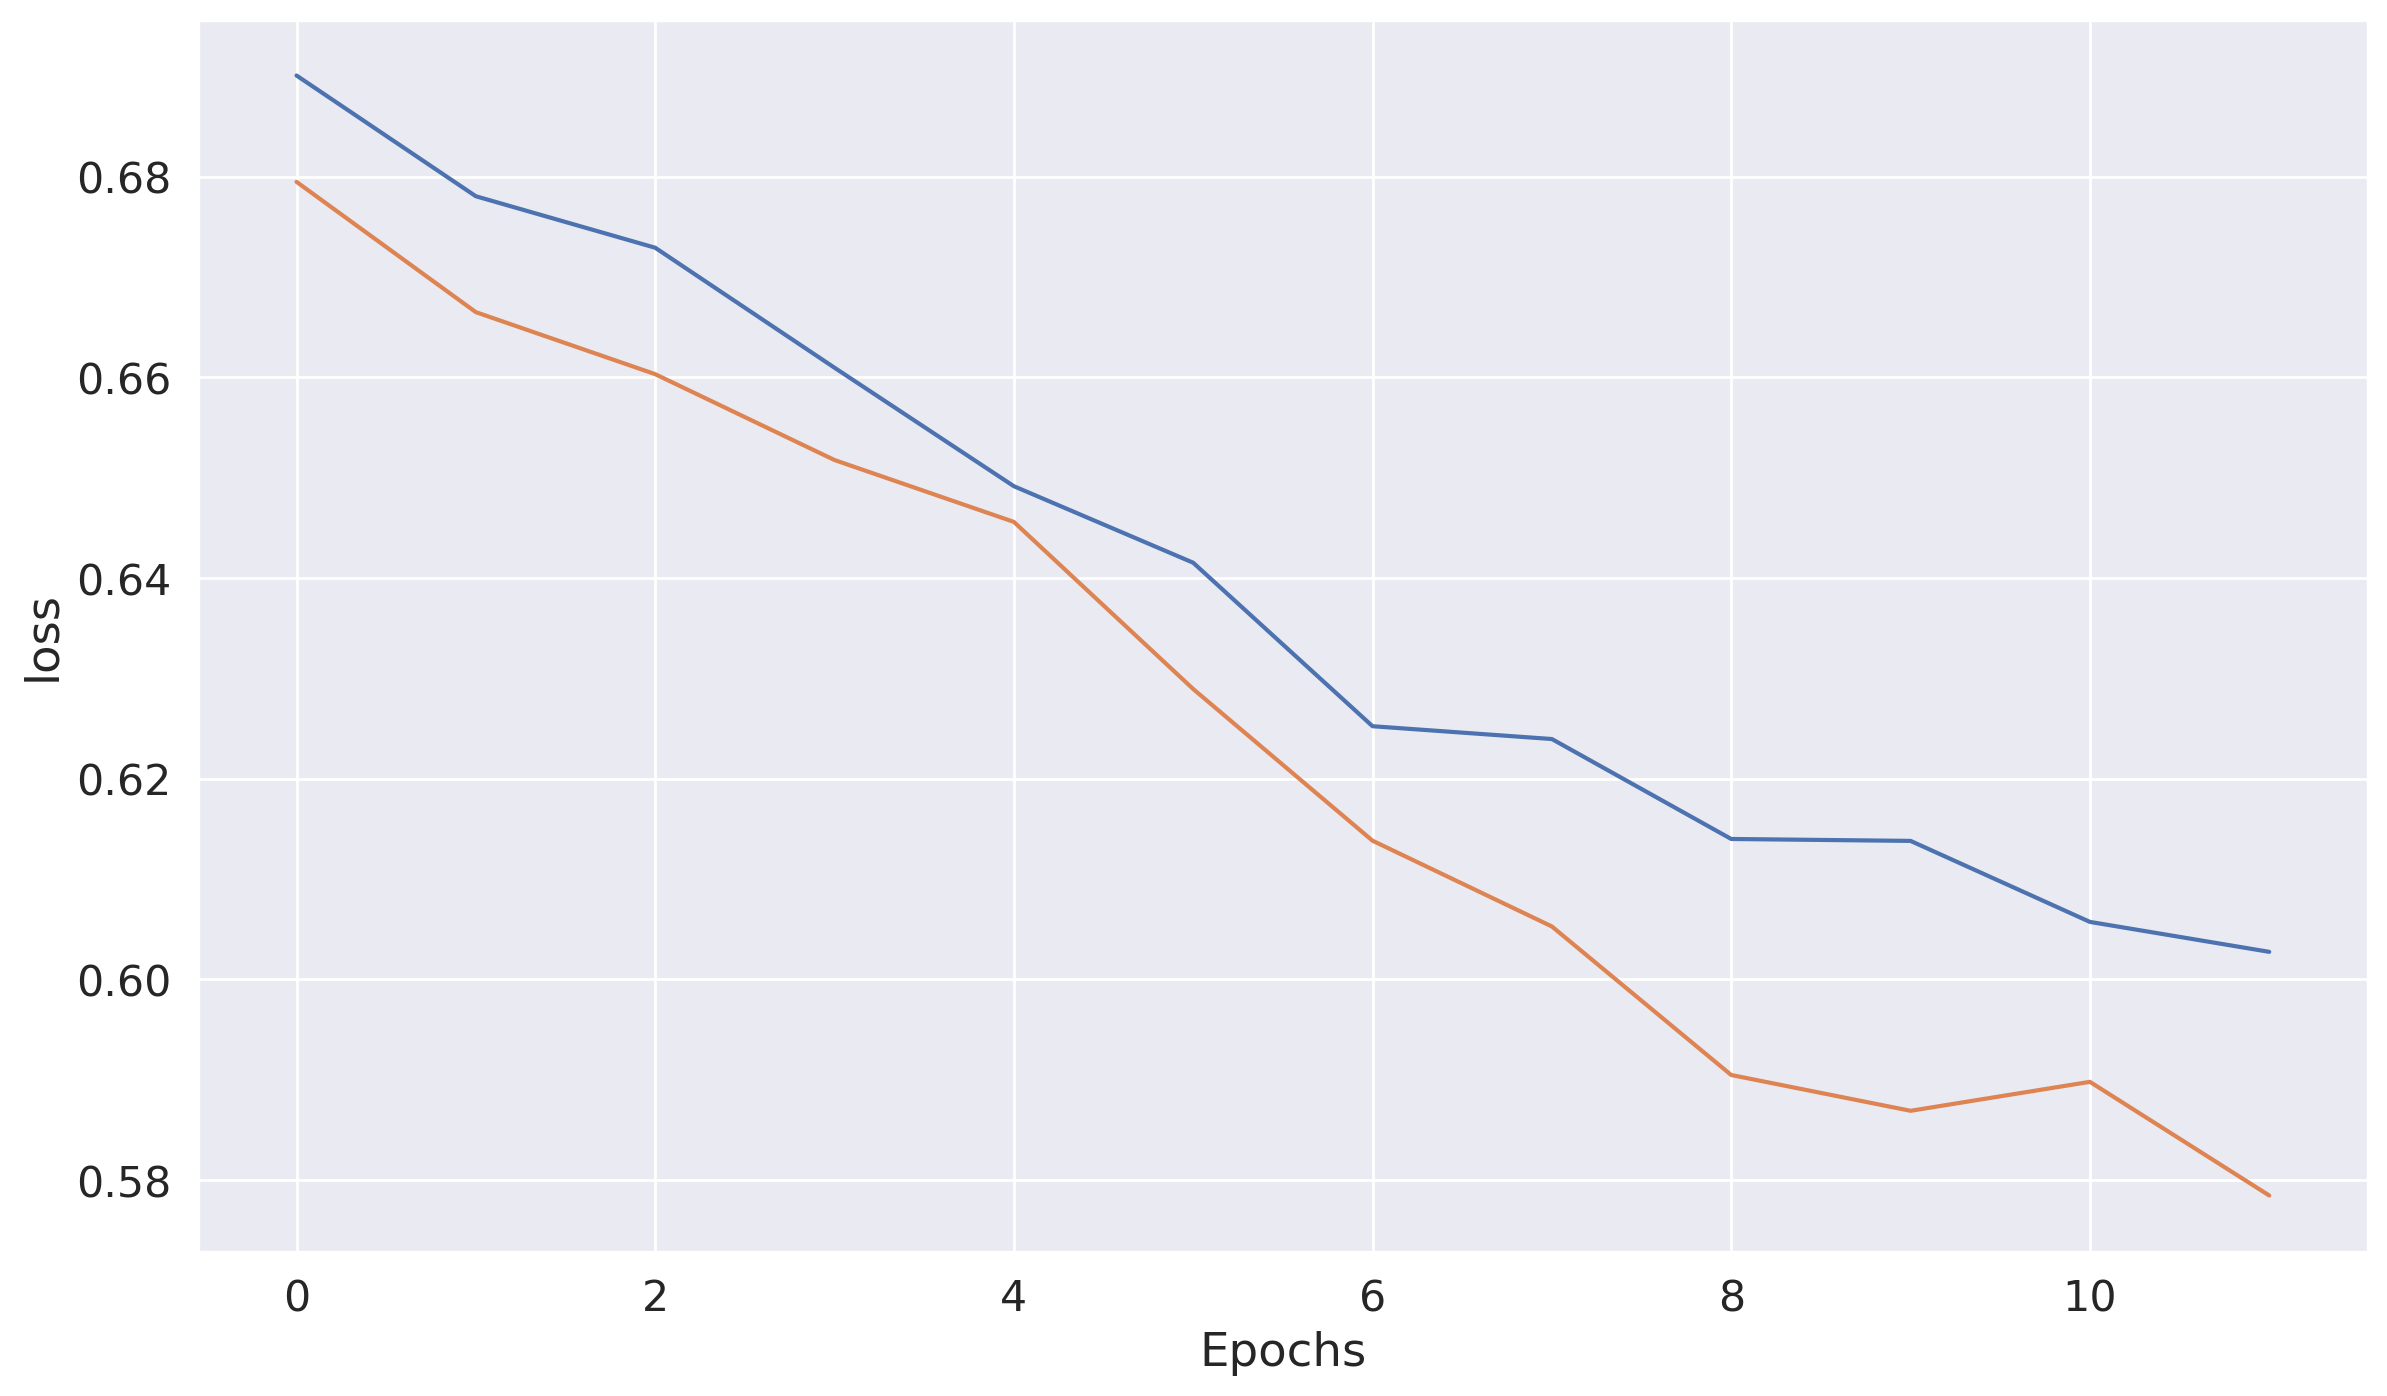

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')

# Model Evaluation

In [ ]:
# Load the best model for testing
best_model = RoBERTa_Arch(roberta).to(device)
best_model.load_state_dict(torch.load('roberta_best_model.pth'))

# Separate testing section
def test_model(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        preds = []
        true_labels = []
        for batch in test_dataloader:
            batch = [t.to(device) for t in batch]
            sent_id, mask, labels = batch
            output = model(sent_id, mask)
            preds.extend(torch.argmax(output, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        return np.array(true_labels), np.array(preds)

# Test the model on the test set
true_labels, preds = test_model(best_model, test_dataloader)
# print(classification_report(test_targets, test_preds))

# Additional testing metrics
conf_matrix = confusion_matrix(true_labels, preds)
accuracy = accuracy_score(true_labels, preds)



In [ ]:
for i in range(20):
    print(f"Example {i + 1}: Predicted Class: {preds[i]}, True Label: {true_labels[i]}")

Example 1: Predicted Class: 1, True Label: 1
Example 2: Predicted Class: 0, True Label: 0
Example 3: Predicted Class: 1, True Label: 1
Example 4: Predicted Class: 0, True Label: 0
Example 5: Predicted Class: 0, True Label: 1
Example 6: Predicted Class: 1, True Label: 1
Example 7: Predicted Class: 1, True Label: 1
Example 8: Predicted Class: 1, True Label: 1
Example 9: Predicted Class: 0, True Label: 0
Example 10: Predicted Class: 1, True Label: 1
Example 11: Predicted Class: 0, True Label: 0
Example 12: Predicted Class: 0, True Label: 0
Example 13: Predicted Class: 1, True Label: 1
Example 14: Predicted Class: 0, True Label: 0
Example 15: Predicted Class: 0, True Label: 0
Example 16: Predicted Class: 1, True Label: 1
Example 17: Predicted Class: 0, True Label: 1
Example 18: Predicted Class: 1, True Label: 0
Example 19: Predicted Class: 0, True Label: 0
Example 20: Predicted Class: 0, True Label: 0


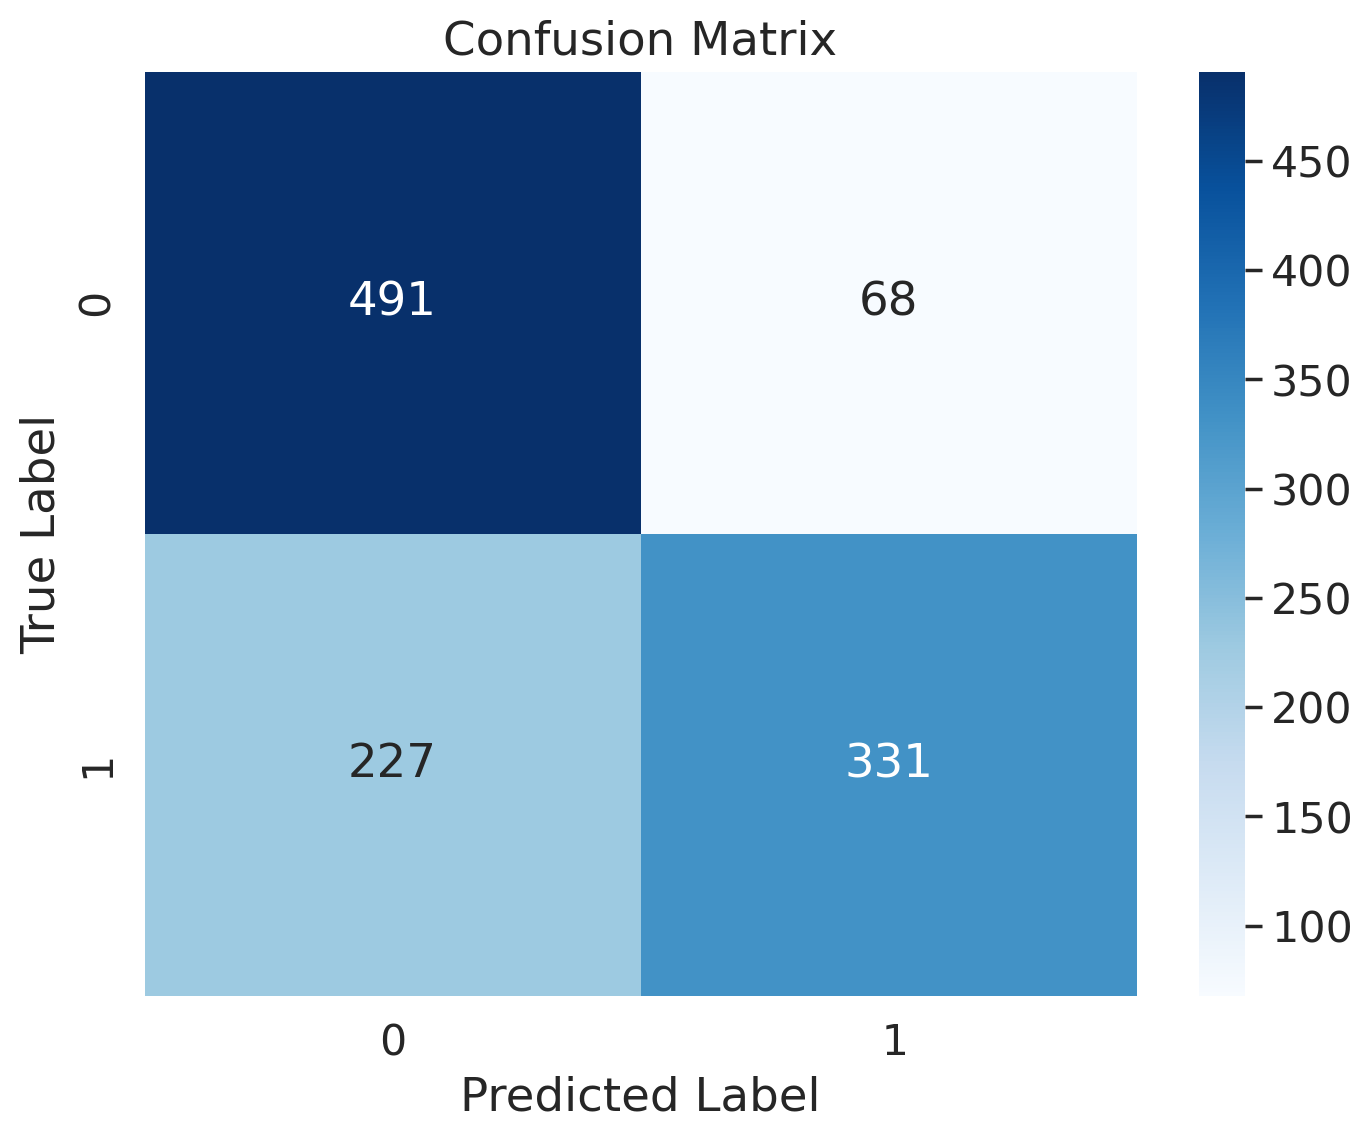

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Test the model on the test set
test_targets, test_preds = test_model(best_model, test_dataloader)

# Create the confusion matrix
conf_matrix = confusion_matrix(test_targets, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0", " 1"],
            yticklabels=["0", "1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
